In [1]:
# general packages
import numpy as np
import os
import sys
import inspect

# H-FISTA packages
currentdir = %pwd 
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from lib import Residual
from fista import fista
from helpers import get_data
from lambda_loop import take_lambda_step, initialize_io_dict, get_initial_lambda
from stopping import check_stopping

# plotting tools
import matplotlib.pyplot as plt
from plotting import make_plots, get_diag_plot, get_paper_figure, get_dynamic_field_plot
from scipy.fft import fftshift

%matplotlib inline

# plot style adjustement, remove if jupyter themes not avaiable
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, ticks=True, grid=False,)

# further plot configuration
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.aspect"] = "auto"
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams["axes.linewidth"] = 3

### Load and plot data

2022-10-27 09:58:14,953 - H-FISTA.helpers - WARNING - Loading data/simulated/simulated_12.5percent_wnoise.pkl as a psrflux ASCII file failed. Trying to load as a FITS file.
2022-10-27 09:58:14,955 - H-FISTA.helpers - WARNING - Loading data/simulated/simulated_12.5percent_wnoise.pkl as a FITS file failed. Trying to load as a pickle


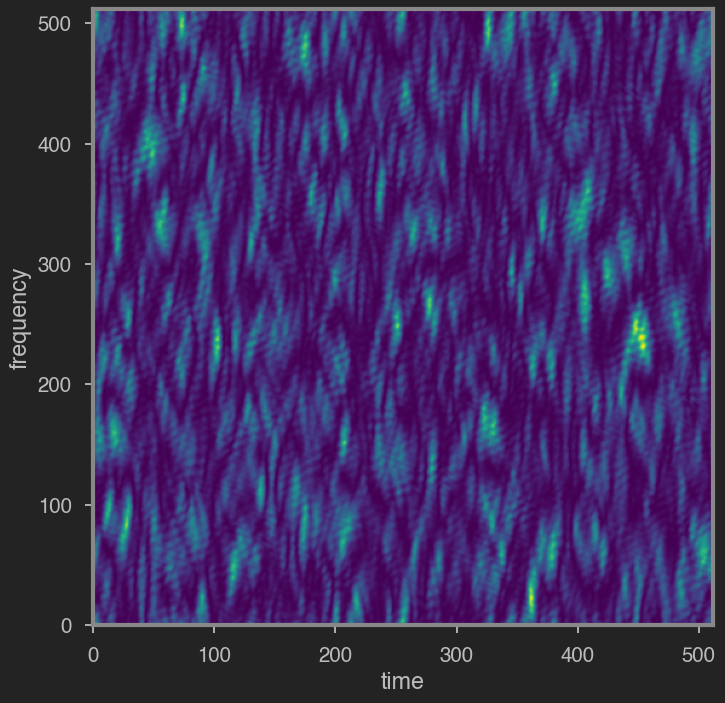

In [2]:
noisy_data_file = "data/simulated/simulated_12.5percent_wnoise.pkl"
data = get_data(noisy_data_file)
plt.imshow(data.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

## HFISTA
### Generate initial values

In [3]:
# initial RFI mask does not mask any data
mask = np.ones_like(data)

# initial guess with all power in one wave at the origin
N, M = data.shape
h_init = np.zeros((N, M)) + np.zeros((N, M)) * 1.0j

init_value = np.sqrt(np.mean(data * mask)) * N * M + 0.0j
init_coords = [0, 0]
h_init[init_coords[0], init_coords[1]] = init_value

# H-FISTA configuration
lambda_scale = 1.15
desired_number_of_components_after_first_step = 60
fix_phase_value = 0.0
fix_phase_coords = init_coords

# FISTA configuration
FISTA_niter = 80
delay_for_inf = -4
backtrack = True
verbose = False

### Initialise I/O dictionary

In [4]:
# pre-populate the rest of the input output dictionary
io = initialize_io_dict()

# setup the initial guess as a step so that we can use the exact same loop for all runs below
step = 0

io["niters"][step] = 0 

# mask = np.ones_like(data) # in this particular case, we already have a mask
io["masks"][step] = mask
resid = Residual(data, h_init, None, mask)
io["lambdas"][step] = get_initial_lambda(desired_number_of_components_after_first_step, delay_for_inf, resid) * lambda_scale
io["models"][step] = h_init
io["demerits"][step] = -1
io["predictions"][step] = resid.prediction
io["residuals"][step] = resid.residual

In [5]:
chosen_step = -1

approved = np.transpose(np.nonzero(h_init))

for step in range(1, 101):
    io["niters"][step] = FISTA_niter
    ref_lambda = io["lambdas"][step-1]/lambda_scale

    lambda_loop_config = {
        "backtrack": backtrack,
        "fix_phase_value": fix_phase_value,
        "fix_phase_coords": init_coords,
        "ref_lambda": ref_lambda, 
        "verbose": verbose,
        "delay_for_inf": delay_for_inf,
        "zero_penalty_coords": approved,
        # "clean_RFI": False, # RFI detection can get overly eager in noise-free cases
    }

    print()
    print(f"### λ iteration {step} with λ={ref_lambda} and scaling {lambda_scale} ###")
    print() 

    approved = take_lambda_step(data, io, step, **lambda_loop_config)
    io["lambdas"][step] = ref_lambda
    
    if step > 1:
        if check_stopping(io, step):
            chosen_step = step - 1
            print(f"Stopping criterion triggered in step {step}")
            break


### λ iteration 1 with λ=7.763107566107701e-08 and scaling 1.15 ###

2022-10-27 09:58:15,565 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1 components (approved: 1 and fixed support 0)
2022-10-27 09:58:16,015 - H-FISTA.fista - INFO - backtrack_B3 found 2.14e-09 after 4 iterations. Model has 62 el.
2022-10-27 09:58:16,039 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 62 non-zero elements with demerit 0.00194
2022-10-27 09:58:21,515 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 64 non-zero elements with demerit 0.00165
2022-10-27 09:58:25,220 - H-FISTA.fista - INFO - Arrived at model with 66 components/ 0.00165 after 80 iterations
2022-10-27 09:58:25,270 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 66 components (approved: 0 and fixed support 66)
2022-10-27 09:58:25,272 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:58:25,709 - H-FISTA.fista - INFO - backtrack_B3 found 1.95e-09 after 3 iterations. Model has 66 el.
2022-10-27 09

2022-10-27 09:59:47,737 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 129 non-zero elements with demerit 0.00074
2022-10-27 09:59:50,804 - H-FISTA.fista - INFO - Arrived at model with 130 components/ 0.00074 after 80 iterations
2022-10-27 09:59:50,828 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 130 components (approved: 0 and fixed support 130)
2022-10-27 09:59:50,830 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:59:50,943 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 130 non-zero elements with demerit 0.000715
2022-10-27 09:59:51,459 - H-FISTA.fista - INFO - backtrack_B3 found 1.82e-09 after 3 iterations. Model has 130 el.
2022-10-27 09:59:51,873 - H-FISTA.fista - INFO - backtrack_B3 found 2.66e-09 after 4 iterations. Model has 130 el.
2022-10-27 09:59:56,761 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 130 non-zero elements with demerit 0.000697
2022-10-27 10:00:00,283 - H-FISTA.fista - INFO - Arrived at model with 130 components/ 0.000

2022-10-27 10:01:16,337 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:01:16,436 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 100 non-zero elements with demerit 0.000108
2022-10-27 10:01:17,221 - H-FISTA.fista - INFO - backtrack_B3 found 2.64e-09 after 7 iterations. Model has 100 el.
2022-10-27 10:01:21,468 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 100 non-zero elements with demerit 0.000104
2022-10-27 10:01:24,272 - H-FISTA.fista - INFO - Arrived at model with 100 components/ 0.000104 after 80 iterations
2022-10-27 10:01:24,283 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 12.730287674706386
2022-10-27 10:01:24,284 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 8 with λ=2.9184396790070927e-08 and scaling 1.15 ###

2022-10-27 10:01:24,312 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 100 components (approved: 100 and fixed support 0)
2022-10-27 10:01:24,41

2022-10-27 10:02:36,575 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 12 with λ=1.668627358539796e-08 and scaling 1.15 ###

2022-10-27 10:02:36,600 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 164 components (approved: 164 and fixed support 0)
2022-10-27 10:02:36,689 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 179 non-zero elements with demerit 3.16e-05
2022-10-27 10:02:37,084 - H-FISTA.fista - INFO - backtrack_B3 found 1.64e-09 after 2 iterations. Model has 179 el.
2022-10-27 10:02:37,677 - H-FISTA.fista - INFO - backtrack_B3 found 3.19e-09 after 7 iterations. Model has 179 el.
2022-10-27 10:02:41,625 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 179 non-zero elements with demerit 3.11e-05
2022-10-27 10:02:44,052 - H-FISTA.fista - INFO - Arrived at model with 179 components/ 3.11e-05 after 80 iterations
2022-10-27 10:02:44,070 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 179 components

2022-10-27 10:03:37,985 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 238 non-zero elements with demerit 1.04e-05
2022-10-27 10:03:38,921 - H-FISTA.fista - INFO - backtrack_B3 found 2.9e-09 after 8 iterations. Model has 238 el.
2022-10-27 10:03:42,866 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 238 non-zero elements with demerit 9.82e-06
2022-10-27 10:03:45,398 - H-FISTA.fista - INFO - Arrived at model with 238 components/ 9.82e-06 after 80 iterations
2022-10-27 10:03:45,404 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 3.289765709433613
2022-10-27 10:03:45,406 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 17 with λ=8.296027025482247e-09 and scaling 1.15 ###

2022-10-27 10:03:45,432 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 238 components (approved: 238 and fixed support 0)
2022-10-27 10:03:45,507 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 252 non-zero 

2022-10-27 10:04:47,174 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 21 with λ=4.743280377346994e-09 and scaling 1.15 ###

2022-10-27 10:04:47,194 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 300 components (approved: 300 and fixed support 0)
2022-10-27 10:04:47,270 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 318 non-zero elements with demerit 4.7e-06
2022-10-27 10:04:47,574 - H-FISTA.fista - INFO - backtrack_B3 found 1.49e-09 after 1 iterations. Model has 318 el.
2022-10-27 10:04:47,985 - H-FISTA.fista - INFO - backtrack_B3 found 2.4e-09 after 5 iterations. Model has 318 el.
2022-10-27 10:04:52,012 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 318 non-zero elements with demerit 4.64e-06
2022-10-27 10:04:53,419 - H-FISTA.fista - INFO - backtrack_B3 found 3.19e-09 after 3 iterations. Model has 318 el.
2022-10-27 10:04:54,742 - H-FISTA.fista - INFO - Arrived at model with 318 components/ 4.64e-06 after 80 it

2022-10-27 10:05:53,825 - H-FISTA.fista - INFO - Arrived at model with 378 components/ 2.93e-06 after 80 iterations
2022-10-27 10:05:53,842 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 378 components (approved: 0 and fixed support 378)
2022-10-27 10:05:53,843 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:05:53,919 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 378 non-zero elements with demerit 2.82e-06
2022-10-27 10:05:54,711 - H-FISTA.fista - INFO - backtrack_B3 found 2.9e-09 after 8 iterations. Model has 378 el.
2022-10-27 10:05:58,287 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 378 non-zero elements with demerit 2.78e-06
2022-10-27 10:06:00,491 - H-FISTA.fista - INFO - Arrived at model with 378 components/ 2.78e-06 after 80 iterations
2022-10-27 10:06:00,498 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.9351567356105598
2022-10-27 10:06:00,500 - H-FISTA.lambda_loop - INFO - RFI mask now includes 

2022-10-27 10:06:46,608 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:06:46,730 - H-FISTA.fista - INFO - backtrack_B3 found 1.49e-09 after 1 iterations. Model has 433 el.
2022-10-27 10:06:46,743 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 433 non-zero elements with demerit 2.43e-06
2022-10-27 10:06:47,478 - H-FISTA.fista - INFO - backtrack_B3 found 2.18e-09 after 4 iterations. Model has 433 el.
2022-10-27 10:06:50,933 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 433 non-zero elements with demerit 2.42e-06
2022-10-27 10:06:53,133 - H-FISTA.fista - INFO - Arrived at model with 433 components/ 2.42e-06 after 80 iterations
2022-10-27 10:06:53,138 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.7116576142010106
2022-10-27 10:06:53,139 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 30 with λ=1.348336321047349e-09 and scaling 1.15 ###

2022-10-27 10:06:53,158 - H-FISTA.fista - INFO -

2022-10-27 10:07:37,979 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 481 components (approved: 0 and fixed support 481)
2022-10-27 10:07:37,980 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:07:38,130 - H-FISTA.fista - INFO - backtrack_B3 found 1.49e-09 after 1 iterations. Model has 481 el.
2022-10-27 10:07:38,147 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 481 non-zero elements with demerit 2.32e-06
2022-10-27 10:07:38,903 - H-FISTA.fista - INFO - backtrack_B3 found 1.98e-09 after 3 iterations. Model has 481 el.
2022-10-27 10:07:39,120 - H-FISTA.fista - INFO - backtrack_B3 found 2.4e-09 after 2 iterations. Model has 481 el.
2022-10-27 10:07:42,730 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 481 non-zero elements with demerit 2.31e-06
2022-10-27 10:07:45,047 - H-FISTA.fista - INFO - Arrived at model with 481 components/ 2.31e-06 after 80 iterations
2022-10-27 10:07:45,055 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep

2022-10-27 10:08:34,107 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.2101422207907088
2022-10-27 10:08:34,110 - H-FISTA.lambda_loop - INFO - RFI mask now includes 8.01 per cent of data

### λ iteration 36 with λ=5.82923000158633e-10 and scaling 1.15 ###

2022-10-27 10:08:34,178 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 519 components (approved: 519 and fixed support 0)
2022-10-27 10:08:34,305 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 533 non-zero elements with demerit 2.27e-06
2022-10-27 10:08:34,789 - H-FISTA.fista - INFO - backtrack_B3 found 1.64e-09 after 2 iterations. Model has 533 el.
2022-10-27 10:08:35,811 - H-FISTA.fista - INFO - backtrack_B3 found 2.9e-09 after 6 iterations. Model has 533 el.
2022-10-27 10:08:39,773 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 533 non-zero elements with demerit 2.26e-06
2022-10-27 10:08:40,188 - H-FISTA.fista - INFO - backtrack_B3 found 3.51e-09 after 2 iter

2022-10-27 10:09:15,583 - H-FISTA.fista - INFO - backtrack_B3 found 2.9e-09 after 1 iterations. Model has 596 el.
2022-10-27 10:09:16,034 - H-FISTA.fista - INFO - backtrack_B3 found 3.19e-09 after 1 iterations. Model has 596 el.
2022-10-27 10:09:16,898 - H-FISTA.fista - INFO - backtrack_B3 found 4.25e-09 after 3 iterations. Model has 596 el.
2022-10-27 10:09:20,344 - H-FISTA.fista - INFO - backtrack_B3 found 7.3e-07 after 54 iterations. Model has 596 el.
2022-10-27 10:09:20,627 - H-FISTA.fista - INFO - backtrack_B3 found 8.03e-07 after 1 iterations. Model has 596 el.
2022-10-27 10:09:20,816 - H-FISTA.fista - INFO - backtrack_B3 found 8.83e-07 after 1 iterations. Model has 596 el.
2022-10-27 10:09:21,327 - H-FISTA.fista - INFO - backtrack_B3 found 1.29e-06 after 4 iterations. Model has 596 el.
2022-10-27 10:09:21,343 - H-FISTA.fista - INFO - Arrived at model with 596 components/ 2.25e-06 after 80 iterations
2022-10-27 10:09:21,358 - H-FISTA.fista - INFO - Running FISTA from an initial g

In [6]:
print(f"chosen step: {chosen_step} sparse wavefield components: {np.count_nonzero(io['models'][chosen_step])}")

chosen step: 38 sparse wavefield components: 596


### Inspect dynamic field progression

#### Plot the magnitude and phase of the dynamic field H

We note that that the magnitude of H is square root of the dynamic spectrum

We plot the dynamic field for the first three λ iterations, and the chosen step. If no step was chosen, we use the last available step

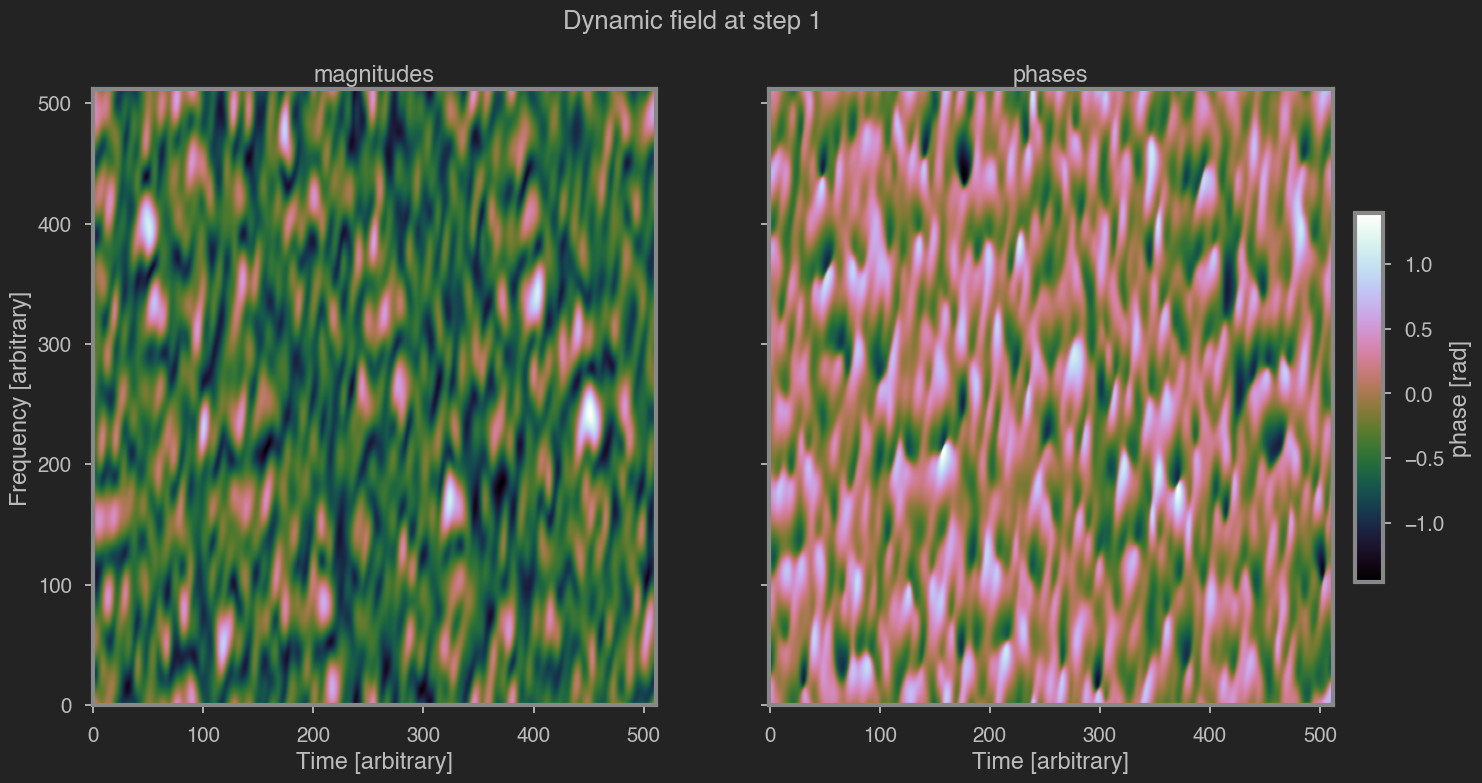

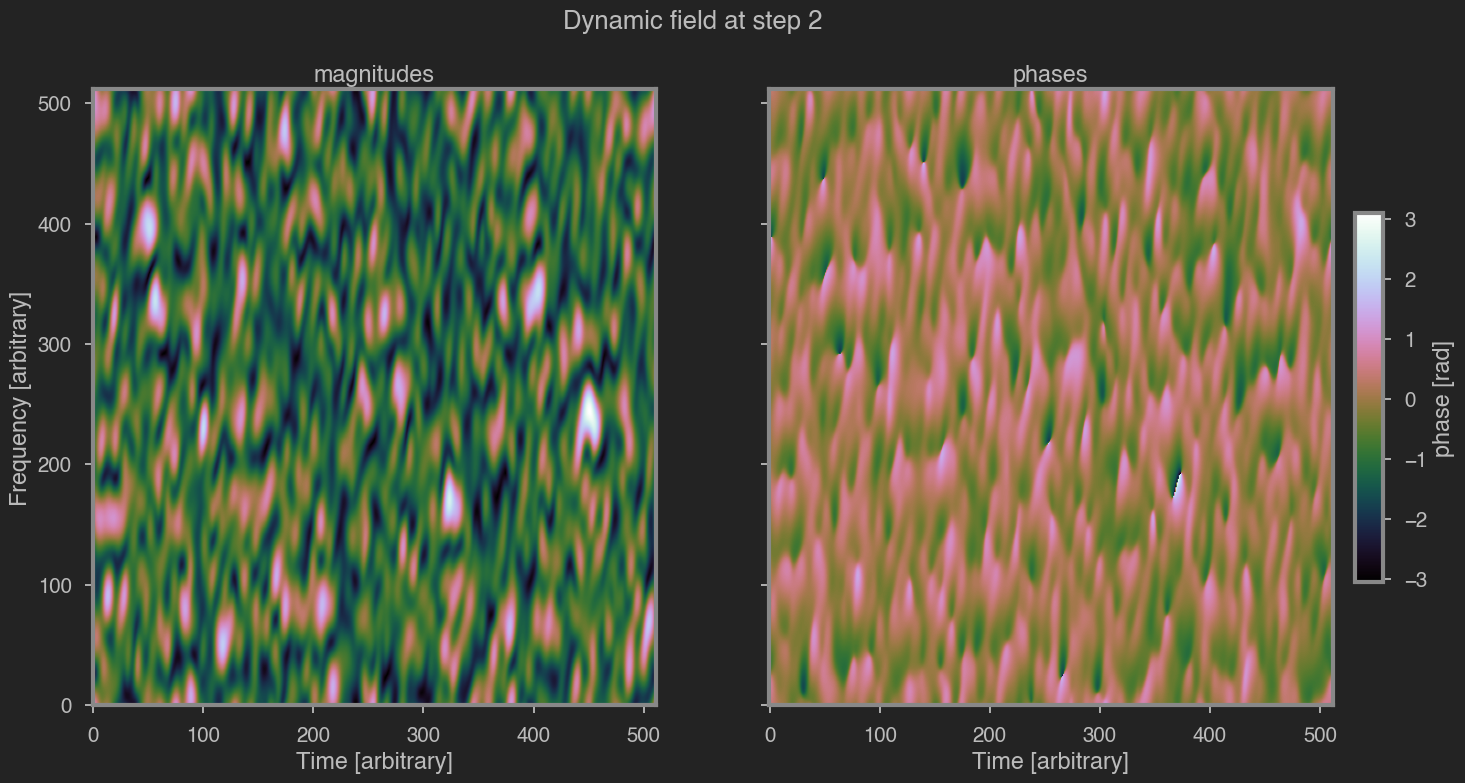

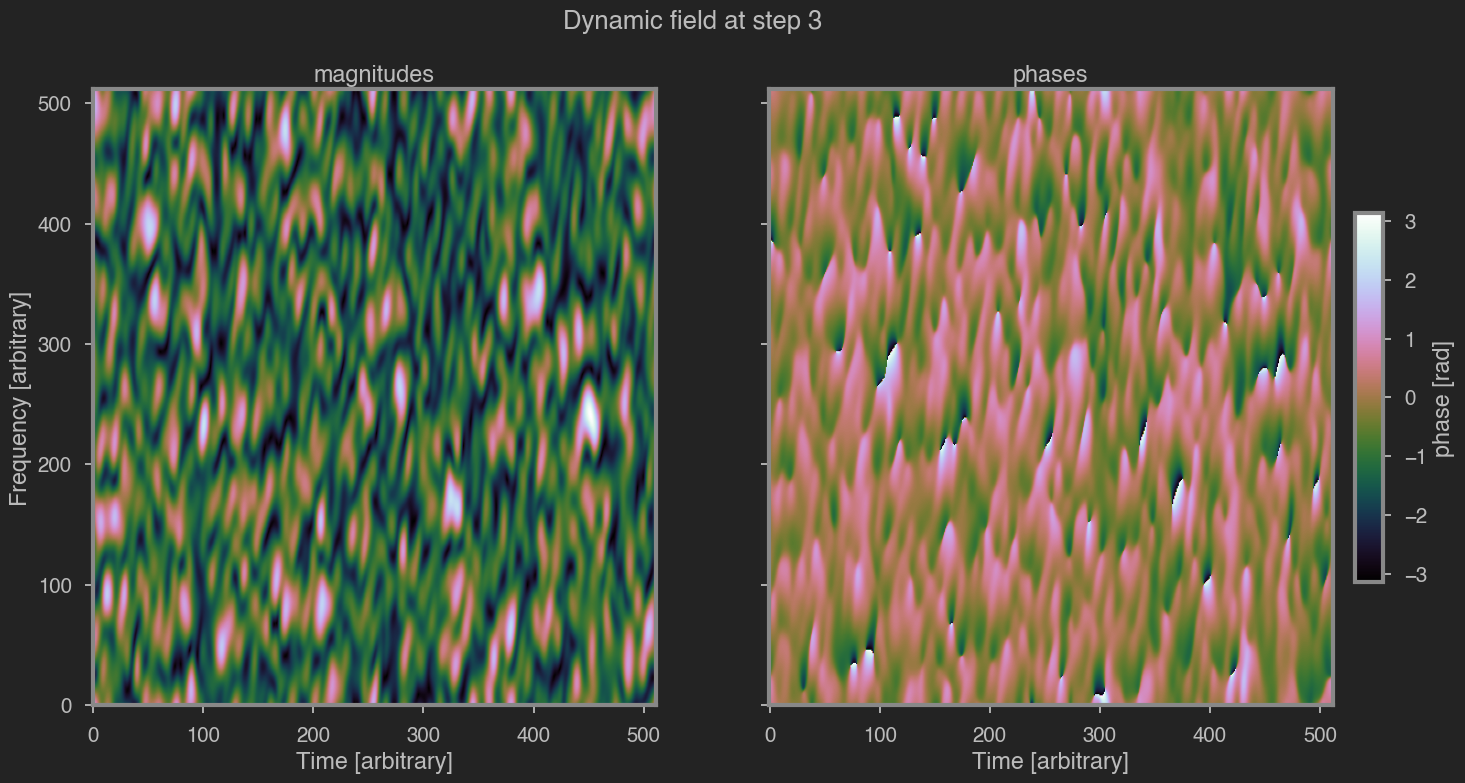

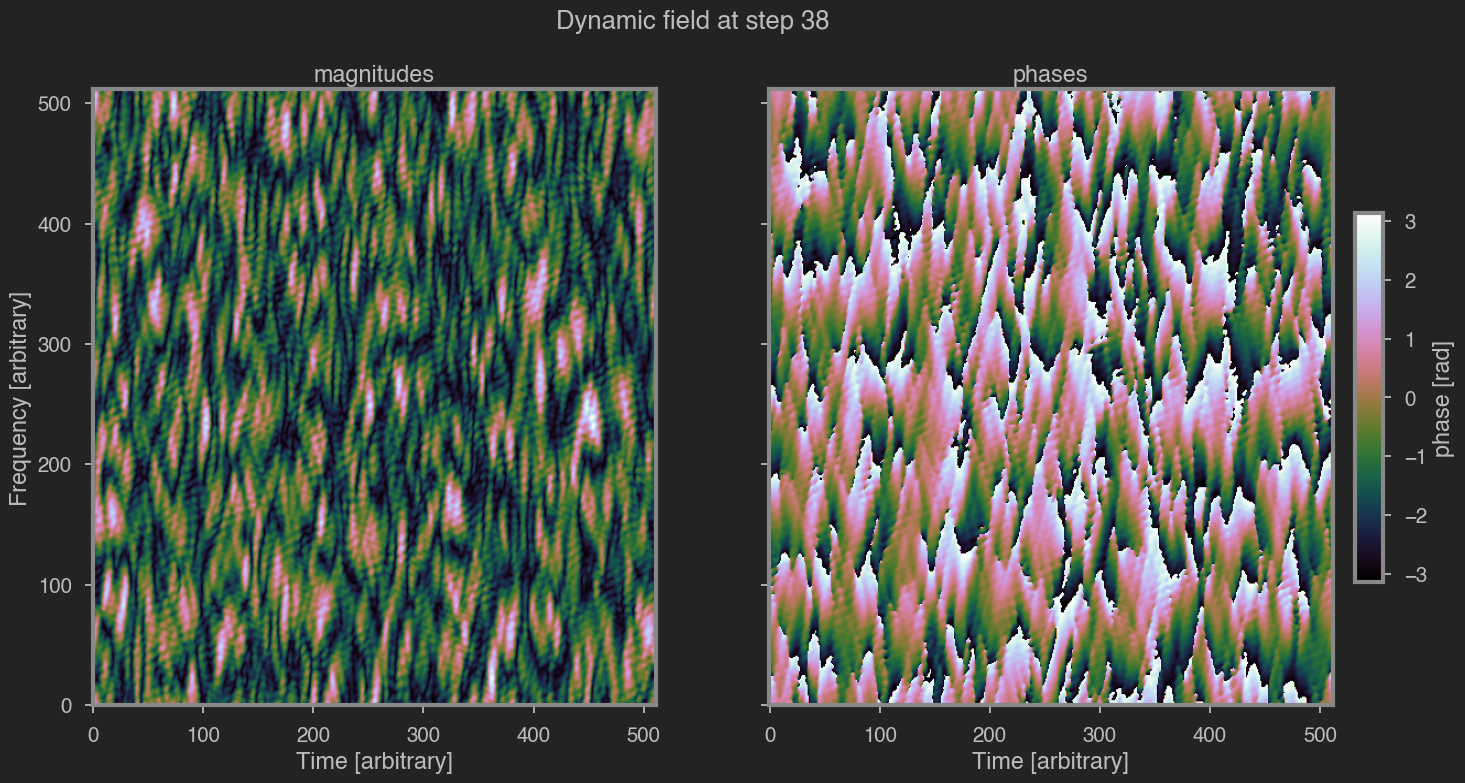

In [7]:
inspect_steps = [1, 2, 3]

if chosen_step > 0:
    inspect_steps.append(chosen_step)
else:
    inspect_steps.append(np.max(list(io["models"].keys())))

for _step in inspect_steps:
    get_dynamic_field_plot(data, io, _step)

### Diagnostic plot

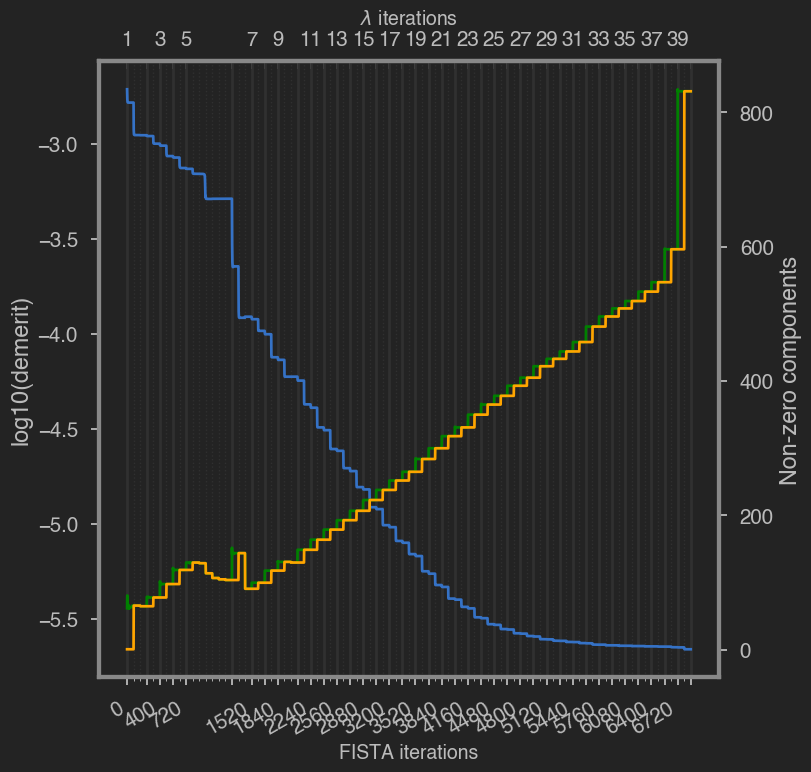

In [8]:
diagnostic_args = {}
if chosen_step > 0:
    diagnostic_args["max_step"] = chosen_step + 1
get_diag_plot(io, **diagnostic_args)

### Refine with unconstrained FISTA

In [9]:
from densify import get_dense_solution

dense_wavefield = get_dense_solution(io["models"][chosen_step], data, io["masks"][chosen_step])

2022-10-27 10:09:55,620 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 596 components (approved: 0 and fixed support 0)
2022-10-27 10:09:56,889 - H-FISTA.fista - INFO - backtrack_B3 found 8.27e-09 after 19 iterations. Model has 262144 el.
2022-10-27 10:09:56,902 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 262144 non-zero elements with demerit 1.1e-06
2022-10-27 10:09:58,772 - H-FISTA.fista - INFO - backtrack_B3 found 9.1e-09 after 1 iterations. Model has 262144 el.
2022-10-27 10:10:00,859 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 262144 non-zero elements with demerit 1.71e-10
2022-10-27 10:10:04,734 - H-FISTA.fista - INFO - in iteration 100, x_np1 has 262144 non-zero elements with demerit 1.72e-11
2022-10-27 10:10:08,771 - H-FISTA.fista - INFO - in iteration 150, x_np1 has 262144 non-zero elements with demerit 4.48e-12
2022-10-27 10:10:12,456 - H-FISTA.fista - INFO - in iteration 200, x_np1 has 262144 non-zero elements with demerit 1.62e-12
2022-10-2

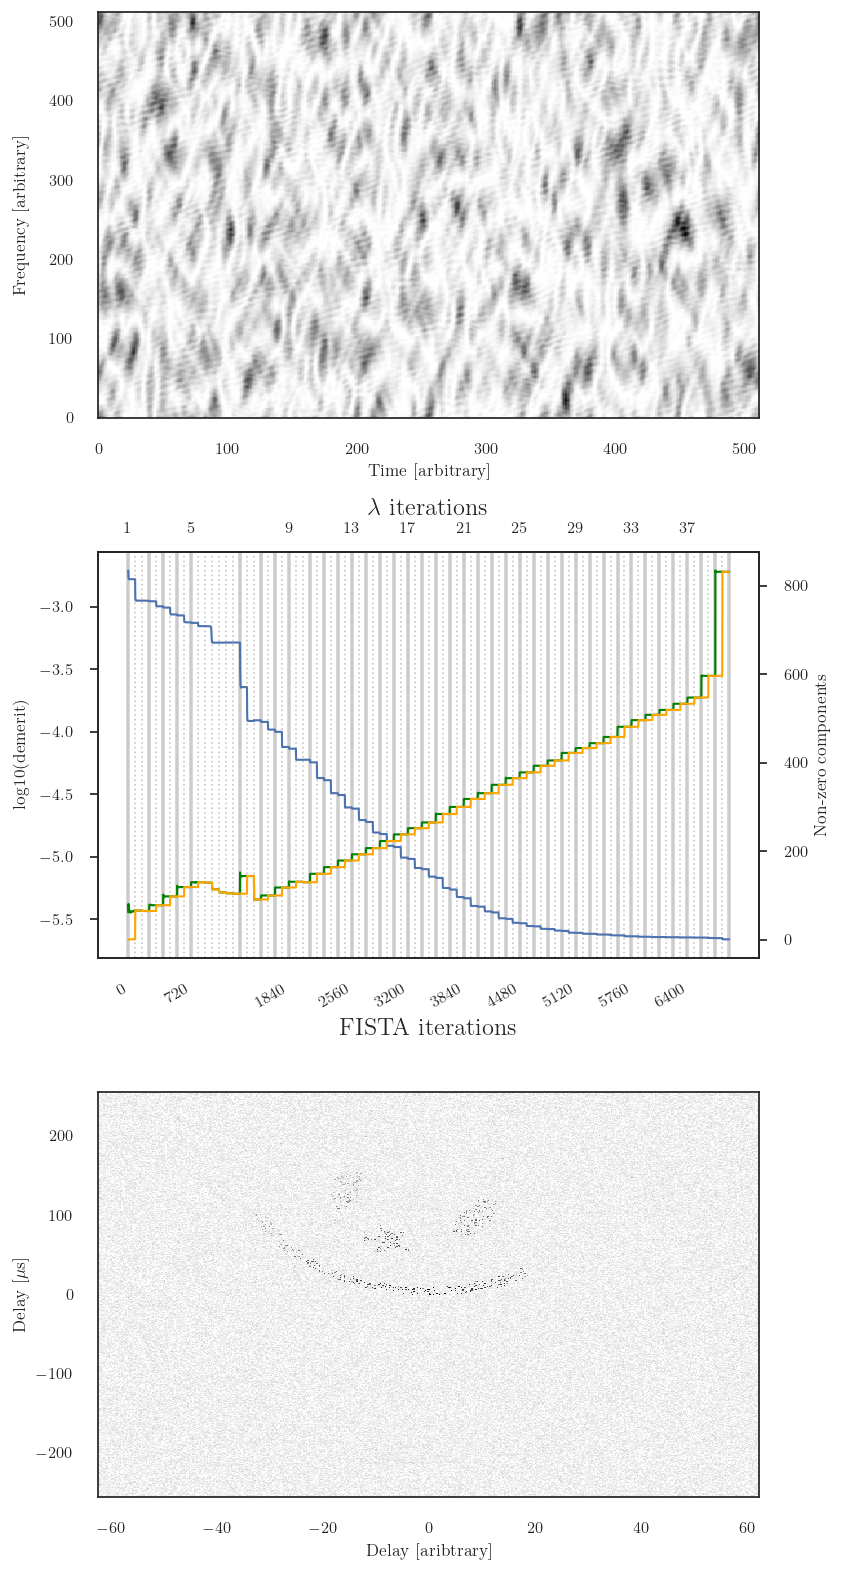

In [10]:
dense_resid = Residual(data, dense_wavefield, None, io["masks"][chosen_step])
fig, axs = get_paper_figure(
    io,
    data,
    chosen_step=chosen_step,
    max_diagnostic_step=chosen_step + 1,
    resid=dense_resid,
    outfn="fig_125_noisy.eps",
    tick_step=4,
    vmin=0.50,
    vmin_data=0,
)

In [22]:
import pickle

with open("output/simulated_12.5_io.pkl", "wb") as fh:
    pickle.dump(io, fh)

with open("output/simulated_12.5_dense.pkl", "wb") as fh:
    pickle.dump(dense_resid, fh)